In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install xformers
!pip install transformers[torch]
!pip install datasets
!pip install  torchtext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import os
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Misc.
import warnings
warnings.filterwarnings('ignore')



In [ ]:
batch_size = 16
MAX_LEN = 160
RANDOM_SEED = 16
MODEL_NAME = 'bert-base-cased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Chatbot/Data/Data-large.csv")


In [ ]:
df.head(5)

,text,intend,category
0,Search for the latest news on Google.,Quary,0
1,Google search for the weather forecast in New ...,Quary,0
2,Find information about space exploration on th...,Quary,0
3,Search for online tutorials on web development.,Quary,0
4,I need to Google something important.,Quary,0


In [ ]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt,truncation=True, max_length=512)
    token_lens.append(len(tokens))

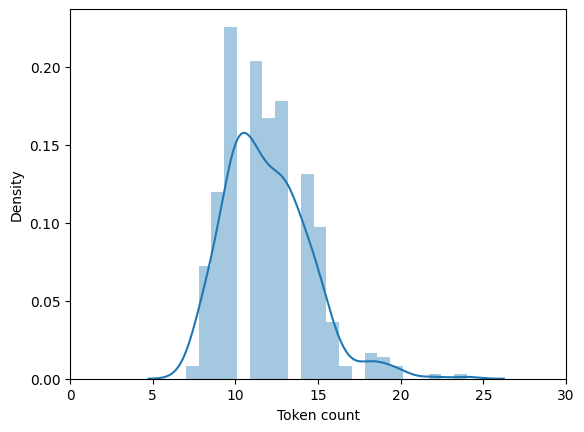

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 30]);
plt.xlabel('Token count');

In [ ]:
class ChatbotDataset(Dataset):
    # Constructor Function
    def __init__(self, text, intend, tokenizer, max_len = 50):

        self.text = text
        self.intend = intend
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.text)

    # get item magic method
    def __getitem__(self, item):

        text_ = str(self.text[item])
        intend_ = self.intend[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            text_,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text_,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'intend': torch.tensor(intend_, dtype=torch.long)
        }




In [ ]:
df_train, df_val= train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ChatbotDataset(
        text=df["text"].to_numpy(),
        intend=df["category"].to_numpy(),
        tokenizer=tokenizer,

    )

    return DataLoader(
        ds,
        batch_size=batch_size,

    )





In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, batch_size)


In [ ]:

data = next(iter(train_data_loader))

print(data)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'text': ['Look up historical landmarks on the web.', 'Find YouTube channels for learning about history.', 'Web search for budget travel tips.', "What's the best way to learn about other cultures?", 'Open YouTube and play a nature documentary.', 'Search for tips on internet safety.', "Add 'Plan a surprise date night' as a task for this month.", 'Open my email inbox.', 'Set an alarm to take medication at 9 AM every day.', "What's your favorite historical period?", 'Search for job postings in the web development field.', "Add 'Submit expense report' as a task for this week.", "What's the secret to finding purpose in life?", 'Email Richard with the contract agreement.', 'Send an email to Amanda with the meeting minutes.', 'Search YouTube for funny cat videos.'], 'input_ids': tensor([[  101,  4785,  1146,  3009, 21308,  1113,  1103,  5127,   119,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['intend'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


In [ ]:
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes = 5):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)


    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
sentiment_int = {'Quary': 0,
                 'Email': 1,
                 'Random': 2,
                 'Task': 3 ,
                 'Youtube': 4  }

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples,bert = True):



    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["intend"].to(device)


        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):

    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["intend"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:



def train(model,EPOCHS = 10):




  print()
  print()
  print()
  print(model)
  print()
  print()
  print()


  optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

  total_steps = len(train_data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
  )

  # Set the loss function
  loss_fn = nn.CrossEntropyLoss().to(device)

  # history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(EPOCHS):


      print(f'Epoch {epoch + 1}/{EPOCHS}')
      print('-' * 20)

      train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
    )



      val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
    )


      print(f' train_loss {train_loss:.5f}  train_acc {train_acc:.5f} <-> Val_loss {val_loss:.5f} val_accuracy {val_acc:.5f}')
      print()

      # history['train_acc'].append(train_acc)
      # history['train_loss'].append(train_loss)
      # history['val_acc'].append(val_acc)
      # history['val_loss'].append(val_loss)


In [ ]:
model = SentimentClassifier(len(sentiment_int))
model = model.to(device)




In [ ]:
train(model,EPOCHS = 10)




SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

100%|██████████| 5/5 [00:00<00:00, 24.89it/s]


 train_loss 0.81930  train_acc 0.70812 <-> Val_loss 0.11359 val_accuracy 0.98571

Epoch 2/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


 train_loss 0.02348  train_acc 1.00000 <-> Val_loss 0.09732 val_accuracy 0.98571

Epoch 3/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 11.31it/s]


 train_loss 0.00231  train_acc 1.00000 <-> Val_loss 0.10137 val_accuracy 0.98571

Epoch 4/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 20.48it/s]


 train_loss 0.00142  train_acc 1.00000 <-> Val_loss 0.10444 val_accuracy 0.98571

Epoch 5/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


 train_loss 0.00120  train_acc 1.00000 <-> Val_loss 0.10658 val_accuracy 0.98571

Epoch 6/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


 train_loss 0.00101  train_acc 1.00000 <-> Val_loss 0.10764 val_accuracy 0.98571

Epoch 7/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


 train_loss 0.00099  train_acc 1.00000 <-> Val_loss 0.10884 val_accuracy 0.98571

Epoch 8/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


 train_loss 0.00089  train_acc 1.00000 <-> Val_loss 0.10945 val_accuracy 0.98571

Epoch 9/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 23.58it/s]


 train_loss 0.00087  train_acc 1.00000 <-> Val_loss 0.10982 val_accuracy 0.98571

Epoch 10/10
--------------------


100%|██████████| 5/5 [00:00<00:00, 24.42it/s]

 train_loss 0.00086  train_acc 1.00000 <-> Val_loss 0.11001 val_accuracy 0.98571



In [ ]:
PATH =  "/content/drive/MyDrive/Chatbot/Models"

model_path = os.path.join(PATH,"Bert_model.pth")

In [ ]:
# torch.save(model.state_dict(), model_path )

In [ ]:
model_trained = SentimentClassifier(len(sentiment_int))

if torch.cuda.is_available() == False:

    print("Cuda Not Present")
    model_trained.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

else:

    print("Cuda Present")
    model_trained.load_state_dict(torch.load(model_path))


model_trained = model_trained.to(device)




